In [1]:
!pip install torch torchvision torchaudio --upgrade

     |████████████████████████████████| 831.4MB 47kB/s s eta 0:00:01     |██████████████                  | 362.0MB 67.2MB/s eta 0:00:07
     |████████████████████████████████| 22.1MB 18.5MB/s eta 0:00:010:00:02     |███████████████▊                | 10.8MB 18.5MB/s eta 0:00:01
     |████████████████████████████████| 1.9MB 16.2MB/s eta 0:00:01
  Found existing installation: torch 1.7.1
    Uninstalling torch-1.7.1:
      Successfully uninstalled torch-1.7.1
  Found existing installation: torchvision 0.8.2
    Uninstalling torchvision-0.8.2:
      Successfully uninstalled torchvision-0.8.2
  Found existing installation: torchaudio 0.7.2
    Uninstalling torchaudio-0.7.2:
      Successfully uninstalled torchaudio-0.7.2


## TS dataset

In [26]:
data_path = '/workspace/TSDataset/' # Beijing PM2.5 dataset (https://archive.ics.uci.edu/ml/machine-learning-databases/00235/) household_power_consumption.txt
"""
@misc{Dua:2019 , author = "Dua, Dheeru and Graff, Casey", year = "2017", title = "{UCI} Machine Learning Repository", url = "http://archive.ics.uci.edu/ml", institution = "University of California, Irvine, School of Information and Computer Sciences" }
"""

'\n@misc{Dua:2019 , author = "Dua, Dheeru and Graff, Casey", year = "2017", title = "{UCI} Machine Learning Repository", url = "http://archive.ics.uci.edu/ml", institution = "University of California, Irvine, School of Information and Computer Sciences" }\n'

In [183]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

import os

from data import HouseholdElectricDataset

In [ ]:
def fill_missing(values):
    one_day = 60 * 24
    for row in range(values.shape[0]):
        for col in range(values.shape[1]):
            if isnan(values[row, col]):
                values[row, col] = values[row - one_day, col]

In [18]:
from numpy import nan
from numpy import isnan


# load all data
dataset = pd.read_csv(data_path, sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])

# mark all missing values
dataset.replace('?', nan, inplace=True)

# make dataset numeric
dataset = dataset.astype('float32')

# fill missing
fill_missing(dataset.values)

In [22]:
values = dataset.values
dataset['sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6])

In [82]:
dataset.max() - dataset.min()

Global_active_power       11.046000
Global_reactive_power      1.390000
Voltage                   30.949997
Global_intensity          48.200001
Sub_metering_1            88.000000
Sub_metering_2            80.000000
Sub_metering_3            31.000000
sub_metering_4           127.233330
dtype: float32

In [23]:
dataset[dataset['Sub_metering_3'].isna()]

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
datetime,,,,,,,,


In [27]:
dataset.to_csv(os.path.join(data_path, 'household_power_consumption.csv'))

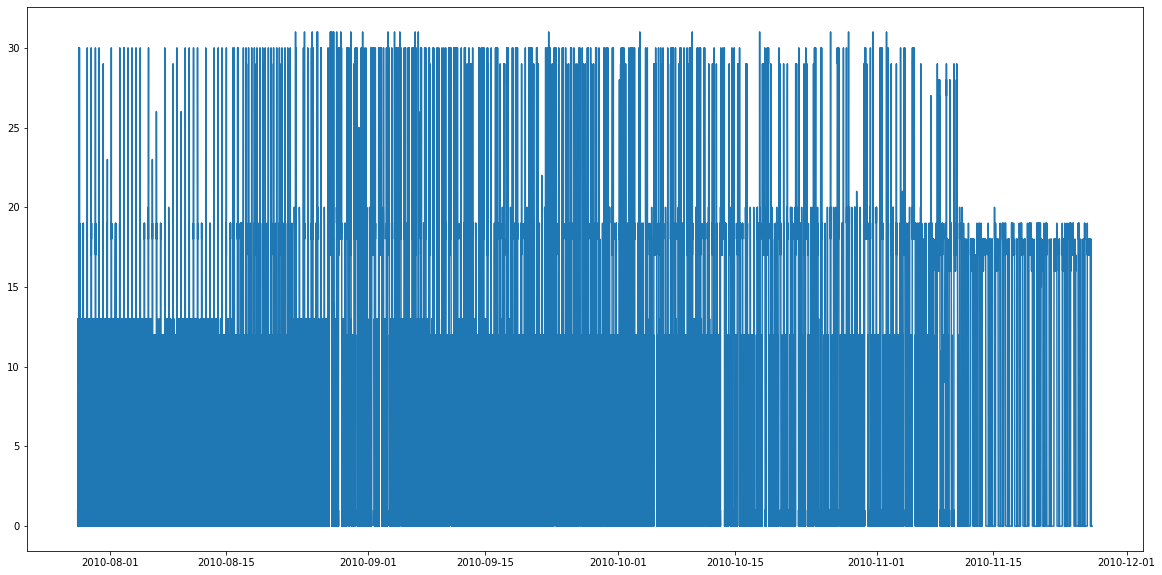

In [31]:
plt.figure(figsize=(20,10))
plt.plot(dataset['Sub_metering_3'][1900000:19001000])

In [32]:
dataset.shape

(2075259, 8)

In [83]:
24*60*7

10080

In [84]:
window_size = 24*7
prediction_length = 24*7 

dilation = 60 # hourly data
test_size=0.2


In [104]:
dt = dataset.resample('%dMin'%dilation).mean()
columns = dt.columns
scaler =  StandardScaler()
dt = scaler.fit_transform(dt)

In [184]:
dataset = HouseholdElectricDataset('household_power_consumption.csv', data_path, window_size, prediction_length)

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

In [ ]:
def make_dataloader(type='train', batch_size=1000):
    if type == 'train':
        loader = get_loader(self.X_train.reshape(self.X_train.shape[0], -1), self.y_train, batch_size)
    elif type == 'valid':
        loader = get_loader(self.X_valid.reshape(self.X_valid.shape[0], -1), self.y_valid, batch_size)
    else:
        loader = get_loader(self.X_test.reshape(self.X_test.shape[0], -1), self.y_test, batch_size)

    return loader

def __channel__(self):
    return self.data.shape[1]

def __len__(self):
    """

    :return: data_size
    """
    return len(self.data)

def save_scaler(self):
    save_data(self.scaler, '../data_', 'scaler.pkl')


def _window_shifting(self):
    """

    :return:
         X_total_train,
         y_total_train,
         X_total_valid,
         y_total_valid,
         X_total_test,
         y_total_test
    """
    X_train, X_test, y_train, y_test = train_test_split(self.data, self.data[:, 4], test_size=self.test_size,
                                                        shuffle=False)

    validation_spot = int(len(X_train) * 0.8)
    test_perm = np.random.permutation(len(X_test) - (self.window_size + self.prediction_length) + 1)

    X_total_test = np.zeros(
        (X_test.shape[0] - (self.window_size + self.prediction_length) + 1, X_test.shape[1], self.window_size))
    y_total_test = np.zeros(
        (X_test.shape[0] - (self.window_size + self.prediction_length) + 1, self.prediction_length))

    X_total_test, y_total_test = self._make_dataset(X_total_test, y_total_test, X_test, test_perm)

    _X_train = X_train[:validation_spot]
    _X_valid = X_train[validation_spot:]
    _y_train = y_train[:validation_spot]
    _y_valid = y_train[validation_spot:]

    perm_train = np.random.permutation(len(_X_train) - (self.window_size + self.prediction_length) + 1)
    perm_valid = np.random.permutation(len(_X_valid) - (self.window_size + self.prediction_length) + 1)

    X_total_train = np.zeros(
        (len(_X_train) - (self.window_size + self.prediction_length) + 1, _X_train.shape[1], self.window_size))
    y_total_train = np.zeros(
        (len(_y_train) - (self.window_size + self.prediction_length) + 1, self.prediction_length))
    X_total_valid = np.zeros(
        (len(_X_valid) - (self.window_size + self.prediction_length) + 1, _X_train.shape[1], self.window_size))
    y_total_valid = np.zeros(
        (len(_y_valid) - (self.window_size + self.prediction_length) + 1, self.prediction_length))

    X_total_train, y_total_train = self._make_dataset(X_total_train, y_total_train, _X_train, perm_train)
    X_total_valid, y_total_valid = self._make_dataset(X_total_valid, y_total_valid, _X_valid, perm_valid)

    return X_total_train, y_total_train, X_total_valid, y_total_valid, X_total_test, y_total_test

def _make_dataset(self, X_total, y_total, data, perm):
    for j, idx in enumerate(perm):
        X = data[idx:idx + self.window_size]
        y = data[idx + self.window_size:idx + self.window_size + self.prediction_length][:, 4]
        X = np.transpose(X)
        X_total[j] = X
        y_total[j] = y

    return X_total, y_total

In [ ]:
# 준형 TODO
def conv_batch_prun(layer, args): ## 잘라낼 index를 return

    
    pass

def fc_prun(layer, args):
    pass

def get_prun_idx(layer, sparsity):
    conv_idxs = None

    for name, module in layer.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            mask = torch.ones_like(module.weight)
            with torch.no_grad():
                for n, param in module.named_parameters():
                    if 'weight' in n:
                        p = param.view(param.shape[0], -1)
                        p = torch.linalg.norm(p, dim=1)
                        lambda_ = p.sort()[0][int(sparsity * p.shape[0])]
                        conv_idxs = p.abs() < lambda_
    return conv_idxs

# Prun
def conv_residual_pattern(prev_conv, residual_block):
    args = get_prun_idx(prev_conv)
    conv_batch_prun(prev_conv, args)
    for residual in residual_block:
        conv_batch_prun(residual.layer2, args)
        
def conv_residual_fc_pattern(prev_conv, residual_block, fc):
    args = get_prun_idx(prev_conv)
    conv_batch_prun(prev_conv, args)
    for residual in residual_block:
        conv_batch_prun(residual.layer2, args)    
    fc_prun(fc, args)    

In [ ]:
# 준형 TODO
def conv_batch_compress_filter(layer, args):
    layer[0].weight = layer[0].weight[args]
    layer[1].weight = layer[1].weight[args]
    pass
    
def conv_batch_compress_channel(layer, args):
    layer[0].weight = layer[0].weight[:, args]
    pass



In [ ]:
def conv_residual_pattern(prev_conv, residual_block):
    args = get_zero_norm_idx(prev_conv)
    
    conv_batch_prun(prev_conv, args)
    for residual in residual_block:
        conv_batch_prun(residual.layer2, args)
        
def conv_residual_fc_pattern(prev_conv, residual_block, fc):
    args = get_prun_idx(prev_conv)
    conv_batch_prun(prev_conv, args)
    for residual in residual_block:
        conv_batch_prun(residual.layer2, args)    
    fc_prun(fc, args)    

## Modeling

In [ ]:
import torch
from torch import nn, optim

In [180]:
input_dim = 8
hidden_dim = [input_dim, 32, 64, 32]
paddings=(0,)*3
output_paddings=(1,1,0)*3
strides=(2,2,2)
kernel_sizes=(5,)*3
dilations=(1,2,4)
enc_l_out = lambda l_in, padding, kernel_size, stride, dilation: int( (l_in + 2 * padding - dilation * (kernel_size - 1) - 1)/stride + 1 )

dec_l_out = lambda l_in, padding, kernel_size, stride, dilation: int( (l_in - 1) * stride - 2 * padding + dilation *(kernel_size - 1) + 1 )

l_in = 7*24

inp = torch.randn(100, 8, l_in) # n, c_in, l_in

enc_convs = nn.Sequential()
for i in range(3):
    enc_convs.add_module('conv%d'%(i+1), nn.Conv1d(hidden_dim[i], hidden_dim[i+1], kernel_sizes[i], strides[i], paddings[i], dilations[i]))
    enc_convs.add_module('relu%d'%(i+1), nn.LeakyReLU())
    l_in = enc_l_out(l_in, paddings[i], kernel_sizes[i], strides[i], dilations[i])
    
fc_in = l_in * hidden_dim[-1]
fc_dims = (fc_in, 256, 256)

enc_fcs = nn.Sequential()
for i in range(2):
    enc_fcs.add_module('fc%d'%(i+1), nn.Linear(fc_dims[i], fc_dims[i+1]))
    

dec_fcs = nn.Sequential()
for i in range(2):
    if i == 0:
        in_c = 128
    else:
        in_c = fc_dims[-1 - i]
    dec_fcs.add_module('fc%d' % (i + 1), nn.Linear(in_c, fc_dims[-2 - i]))


dec_convs = nn.Sequential()
for i in range(3):
    dec_convs.add_module('conv%d'%(i+1), nn.ConvTranspose1d(hidden_dim[-1 - i], hidden_dim[-2 - i], kernel_sizes[-1 - i], strides[-1 - i], paddings[-1 - i], output_paddings[-1 - i], dilation=dilations[-1 - i]))
    dec_convs.add_module('relu%d'%(i+1), nn.LeakyReLU())
#     l_in = dec_l_out(l_in, paddings[i], kernel_sizes[i], strides[i], dilations[i])

In [181]:
def reparameterize(mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return mu + eps*std

In [182]:
print(inp.shape)
out = enc_convs(inp)
print(out.shape)
out = out.view(out.shape[0], -1)
print(out.shape)
out = enc_fcs(out)
print(out.shape)
mu, logvar = out[:, :128], out[:, 128:]
print(mu.shape, logvar.shape)
out = reparameterize(mu, logvar)
print(out.shape)
out = dec_fcs(out)
print(out.shape)
out = out.reshape(out.shape[0], int(out.shape[1]/l_in), l_in)
print(out.shape)
out = dec_convs(out)
print(out.shape)


torch.Size([100, 8, 168])
torch.Size([100, 32, 11])
torch.Size([100, 352])
torch.Size([100, 256])
torch.Size([100, 128]) torch.Size([100, 128])
torch.Size([100, 128])
torch.Size([100, 352])
torch.Size([100, 32, 11])
torch.Size([100, 8, 168])


In [172]:
out.shape

torch.Size([100, 8, 165])

In [81]:
l_in, out.shape, out.view(inp.shape[0], -1).shape

(170, torch.Size([100, 32, 170]), torch.Size([100, 5440]))

torch.Size([100, 45184])

In [1]:
from data import mnist
from models import L0LeNet

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from torch import nn, optim
import torch

from collections import OrderedDict
import time

from utils import AverageMeter

from copy import deepcopy

import torch.nn.functional as F

In [2]:
train_loader, val_loader, num_classes = mnist()

model = L0LeNet(10, device=5)
model.train()

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


L0LeNet(
  (convs): Sequential(
    (conv1): L0Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), sparse_ratio=0.0)
    (relu1): ReLU()
    (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): L0Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), sparse_ratio=0.0)
    (relu2): ReLU()
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fcs): Sequential(
    (fc1): L0Dense(1024 -> 256, sparse_ratio=0.0)
    (relu3): ReLU()
    (fc2): L0Dense(256 -> 256, sparse_ratio=0.0)
    (relu4): ReLU()
    (fc3): L0Dense(256 -> 10, sparse_ratio=0.0)
  )
)

In [3]:
criterion = nn.CrossEntropyLoss().to('cuda:5')
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
def iteration(model, loader, criterion, name='L0LeNet', isTrain=True, isConstrain=False, print_freq=100,
              optimizer=None, epoch=0):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    end = time.time()

    total_softmax = []
    total_labels = []
    total_preds = []

    model.train() if isTrain else model.eval()

    for i, (X, y) in enumerate(loader):
        data_time.update(time.time() - end)
        if torch.cuda.is_available():
            X, y = X.to('cuda:5'), y.to('cuda:5')

        pred = model(X)
        loss = criterion(pred, y)
        losses.update(loss.data, X.size(0))

        if isTrain:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if isConstrain:
            layers = model.layers
            for layer in layers:
                layer.clamp_params()

        # get metric
        pred = F.softmax(pred)
        _, p_data = pred.data.max(dim=1)
        s_data, y_data = pred.data.cpu().detach().numpy(), y.data.cpu().detach().numpy()
        p_data = p_data.cpu().detach().numpy()

        total_softmax.append(s_data)
        total_labels.append(y_data)
        total_preds.append(p_data)

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if i % print_freq == 0:
            print(' Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                epoch, i, len(loader), batch_time=batch_time,
                data_time=data_time, loss=losses))

    total_softmax = reshape_resulting_array(total_softmax)
    total_labels = np.array(total_labels).reshape(-1).squeeze()
    total_preds = np.array(total_preds).reshape(-1).squeeze()

    result = accuracy(total_labels, total_preds, total_softmax)

    # if save_state:
    state = {
        'name': name,
        'epoch': epoch + 1,
        'state_dict': deepcopy(model).cpu().state_dict(),
        'results': result,
        'loss': losses.avg.detach().cpu().numpy(),
        'softmax_output': total_softmax,
        'labels': total_labels,
        'preds': total_preds
    }
    
    if isTrain:
        state['optimizer'] = deepcopy(optimizer).state_dict()

    return state

In [13]:
state = iteration(model, train_loader, criterion, optimizer=optimizer)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


 Epoch: [0][0/600]	Time 0.413 (0.413)	Data 0.392 (0.392)	Loss nan (nan)	
 Epoch: [0][100/600]	Time 0.004 (0.011)	Data 0.000 (0.004)	Loss nan (nan)	
 Epoch: [0][200/600]	Time 0.003 (0.009)	Data 0.000 (0.002)	Loss nan (nan)	
 Epoch: [0][300/600]	Time 0.007 (0.008)	Data 0.000 (0.002)	Loss nan (nan)	
 Epoch: [0][400/600]	Time 0.007 (0.008)	Data 0.000 (0.001)	Loss nan (nan)	
 Epoch: [0][500/600]	Time 0.008 (0.008)	Data 0.000 (0.001)	Loss nan (nan)	


NameError: name 'reshape_resulting_array' is not defined

In [7]:
model.load_state_dict(torch.load('mnist.pth'))

<All keys matched successfully>

In [4]:
print_freq = 200
l0 = False

for epoch in range(100):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    end = time.time()
    for i, (X, y) in enumerate(train_loader):
        data_time.update(time.time() - end)
        if torch.cuda.is_available():
            X, y = X.to('cuda:5'), y.to('cuda:5')

    #     input_X = torch.autograd.Variable(X)
    #     input_X = torch.autograd.Variable(X)

        out = model(X)

        loss = criterion(out, y)

        losses.update(loss.data, X.size(0))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if l0:
            layers = model.layers
            for layer in layers:
                layer.clamp_params()
                
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
                
        if i % print_freq == 0:
            print(' Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                epoch, i, len(train_loader), batch_time=batch_time,
                data_time=data_time, loss=losses))
        
            
    
    

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


 Epoch: [0][0/600]	Time 0.435 (0.435)	Data 0.407 (0.407)	Loss 124107.2500 (124107.2500)	
 Epoch: [0][200/600]	Time 0.006 (0.009)	Data 0.000 (0.002)	Loss 354.4209 (11379.6836)	
 Epoch: [0][400/600]	Time 0.006 (0.008)	Data 0.000 (0.001)	Loss 50.7685 (5776.6714)	
 Epoch: [1][0/600]	Time 0.391 (0.391)	Data 0.379 (0.379)	Loss 35.5763 (35.5763)	
 Epoch: [1][200/600]	Time 0.009 (0.009)	Data 0.001 (0.002)	Loss 6.0891 (26.1717)	
 Epoch: [1][400/600]	Time 0.007 (0.008)	Data 0.000 (0.001)	Loss 12.7649 (26.1831)	


Exception ignored in: <function _releaseLock at 0x7fe198a028c0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt


RuntimeError: DataLoader worker (pid(s) 5635, 5636) exited unexpectedly

In [42]:
isTrain = False

model.train() if isTrain else model.eval()

L0LeNet(
  (convs): Sequential(
    (conv1): L0Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), sparse_ratio=0.0)
    (relu1): ReLU()
    (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): L0Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), sparse_ratio=0.0)
    (relu2): ReLU()
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fcs): Sequential(
    (fc1): L0Dense(1024 -> 256, sparse_ratio=0.0)
    (relu3): ReLU()
    (fc2): L0Dense(256 -> 256, sparse_ratio=0.0)
    (relu4): ReLU()
    (fc3): L0Dense(256 -> 10, sparse_ratio=0.0)
  )
)

In [43]:
model.training

False

In [98]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from torch.utils.tensorboard import SummaryWriter

In [46]:
all_outs

(10000, 10)

In [ ]:
directory = 'logs/{}/'.format('L0LeNet5')
if os.path.exists(directory):
    shutil.rmtree(directory)
    os.makedirs(directory)
else:
    os.makedirs(directory)
writer = SummaryWriter(directory)

In [ ]:
def save_model(model, path='.'):
    net = deepcopy(model)
    state = net.cpu().state_dict()
    torch.save(state, path)
    
def save_checkpoint(state, is_best, name, filename='checkpoint.pth.tar'):
    """Saves checkpoint to disk"""
    directory = "runs/%s/" % name
    if not os.path.exists(directory):
        os.makedirs(directory)
    filename = directory + filename
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'runs/%s/' % name + 'model_best.pth.tar')

In [ ]:
def preTrain(name='l0Lenet5_pretrain'):
    best_valid_loss = 999999
    for epoch in range(EPOCH):
        train_state = iteration(model, train_loader, criterion, isTrain=True, isConstrain=False, optimizer=optimizer, epoch=epoch)
        valid_state = iteration(model, val_loader, criterion, isTrain=False, isConstrain=False, print_freq=10000, epoch=epoch)
        
        train_loss = train_state['loss']
        valid_loss = valid_state['loss']
        
        if best_valid_loss > valid_loss:
            best_valid_loss = valid_loss
            isBest = True
        
        save_checkpoint(train_state, isBest, name + '/train', filename='checkpoint_train.pth.tar')
        save_checkpoint(valid_state, isBest, name + '/valid', filename='checkpoint_valid.pth.tar')
        
        isBest = False
            
        

In [134]:
def accuracy(y_data, p_data, s_data):
    """Computes the precision@k for the specified values of k"""
    
    f1 = f1_score(y_data, p_data, average='micro')
    acc = accuracy_score(y_data, p_data)
    auc = roc_auc_score(y_data, s_data, multi_class='ovo')
    pre = precision_score(y_data, p_data, average='micro')
    rec = recall_score(y_data, p_data, average='micro')
    
    return {
        'f1': f1,
        'accuracy': acc,
        'auc_score': auc,
        'precision': pre,
        'recall': rec
    }


def reshape_resulting_array(arr):
    if type(arr) is not np.ndarray:
        arr = np.array(arr)
    return arr.reshape((-1, arr.shape[-1]))

In [178]:
state = iteration(model, train_loader, criterion, isTrain=False, epoch=0)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


 Epoch: [0][0/600]	Time 0.422 (0.422)	Data 0.400 (0.400)	Loss 0.0000 (0.0000)	
 Epoch: [0][100/600]	Time 0.002 (0.008)	Data 0.000 (0.005)	Loss 0.0031 (0.0020)	
 Epoch: [0][200/600]	Time 0.003 (0.006)	Data 0.001 (0.004)	Loss 0.0012 (0.0025)	
 Epoch: [0][300/600]	Time 0.006 (0.005)	Data 0.004 (0.003)	Loss 0.0000 (0.0023)	
 Epoch: [0][400/600]	Time 0.010 (0.005)	Data 0.007 (0.002)	Loss 0.0010 (0.0026)	
 Epoch: [0][500/600]	Time 0.003 (0.004)	Data 0.001 (0.002)	Loss 0.0000 (0.0027)	


In [182]:
a = []
a.append(state['loss'])

In [103]:
def iteration(model, loader, criterion, isTrain=True, isConstrain=False, print_freq=100, optimizer=None, epoch=None):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    end = time.time()

    all_outs = []
    all_labels = []
    
    model.train() if isTrain else model.eval()

    for i, (X, y) in enumerate(val_loader):
        data_time.update(time.time() - end)
        if torch.cuda.is_available():
            X, y = X.to('cuda:5'), y.to('cuda:5')

    #     input_X = torch.autograd.Variable(X)
    #     input_X = torch.autograd.Variable(X)

        out = model(X)

        all_outs.append(out.detach().cpu().numpy())
        all_labels.append(y.detach().cpu().numpy())

        loss = criterion(out, y)

        losses.update(loss.data, X.size(0))
        
        if isTrain:

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if isConstrain:
            layers = model.layers
            for layer in layers:
                layer.clamp_params()
                
                
        # get metric
        pred = F.softmax(pred)
        _, p_data = pred.data.max(dim=1)
        s_data, y_data = pred.data.cpu().detach().numpy(), y.data.cpu().detach().numpy()
        p_data = p_data.cpu().detach().numpy()        
        

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if i % print_freq == 0:
            print(' Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                epoch, i, len(train_loader), batch_time=batch_time,
                data_time=data_time, loss=losses))
    
    
    
    
    return losses

In [157]:
isConstrain = False
isTrain=False

batch_time = AverageMeter()
data_time = AverageMeter()
losses = AverageMeter()
end = time.time()

total_softmax = []
total_labels = []
total_preds = []

model.train() if isTrain else model.eval()

for i, (X, y) in enumerate(train_loader):
    data_time.update(time.time() - end)
    if torch.cuda.is_available():
        X, y = X.to('cuda:5'), y.to('cuda:5')

#     input_X = torch.autograd.Variable(X)
#     input_X = torch.autograd.Variable(X)

    pred = model(X)

#     all_outs.append(out.detach().cpu().numpy())
#     all_labels.append(y.detach().cpu().numpy())

    loss = criterion(pred, y)

    losses.update(loss.data, X.size(0))

    if isTrain:

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if isConstrain:
        layers = model.layers
        for layer in layers:
            layer.clamp_params()
            
    # get metric
    pred = F.softmax(pred)
    _, p_data = pred.data.max(dim=1)
    s_data, y_data = pred.data.cpu().detach().numpy(), y.data.cpu().detach().numpy()
    p_data = p_data.cpu().detach().numpy()
    
    total_softmax.append(s_data)
    total_labels.append(y_data)
    total_preds.append(p_data)

    # measure elapsed time
    batch_time.update(time.time() - end)
    end = time.time()
    if i % print_freq == 0:
        print(' Epoch: [{0}][{1}/{2}]\t'
              'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
              'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
              'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
            epoch, i, len(train_loader), batch_time=batch_time,
            data_time=data_time, loss=losses))

#     if i == 10: break

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


 Epoch: [20][0/600]	Time 0.381 (0.381)	Data 0.374 (0.374)	Loss 0.0000 (0.0000)	
 Epoch: [20][100/600]	Time 0.002 (0.008)	Data 0.000 (0.005)	Loss 0.0020 (0.0035)	
 Epoch: [20][200/600]	Time 0.003 (0.005)	Data 0.001 (0.003)	Loss 0.0000 (0.0027)	
 Epoch: [20][300/600]	Time 0.003 (0.005)	Data 0.001 (0.002)	Loss 0.0139 (0.0025)	
 Epoch: [20][400/600]	Time 0.004 (0.004)	Data 0.000 (0.002)	Loss 0.0004 (0.0026)	
 Epoch: [20][500/600]	Time 0.003 (0.004)	Data 0.000 (0.002)	Loss 0.0004 (0.0026)	


In [158]:
total_softmax = reshape_resulting_array(total_softmax)
total_labels = np.array(total_labels).reshape(-1).squeeze()
total_preds = np.array(total_preds).reshape(-1).squeeze()

In [164]:
total_softmax.var(axis=0)

array([0.08898716, 0.09981051, 0.08910993, 0.09161435, 0.08738621,
       0.08209218, 0.08894475, 0.09311083, 0.08767661, 0.089401  ],
      dtype=float32)

In [152]:
result = accuracy(total_labels, total_preds, total_softmax)

In [ ]:

state = {
    'epoch': epoch + 1,
    'state_dict': deepcopy(model).cpu().state_dict(),
    'optimizer': deepcopy(optimizer).state_dict(),
    'results': result
}
    
# save_checkpoint(state, is_best)
    
if tensorboard:
    writer.close()

In [65]:
topk = (1,)
maxk = max(topk)

out.data.t().shape

torch.Size([10, 100])

In [22]:
all_outs = np.array(all_outs).reshape(-1, 10)
all_labels = np.array(all_labels).reshape(-1)

In [26]:
m = nn.Softmax(dim=1)
input = torch.randn(2, 3)
output = m(input)

In [27]:
maxk = max(topk)
batch_size = target.size(0)

tensor([[0.2279, 0.4722, 0.2999],
        [0.4725, 0.1987, 0.3288]])

In [24]:
all_labels

array([7, 8, 3, ..., 3, 4, 6])

In [15]:
maxk = max((1,))

_, pred = out.data.topk(maxk, 1, True, True)
pred.t()

In [ ]:
pred.eq()

In [21]:
correct = pred.eq(y.data.view(1, -1).expand_as(pred))

RuntimeError: The expanded size of the tensor (1) must match the existing size (100) at non-singleton dimension 1.  Target sizes: [100, 1].  Tensor sizes: [1, 100]

In [11]:
out.data, y.data

(tensor([[ 1.6940e+35, -4.0876e+35,  1.5291e+35,  1.2766e+35, -1.1093e+35,
           2.1263e+35,  1.5256e+35,  5.6608e+35,  9.3236e+33,  1.3016e+35],
         [ 1.6940e+35, -4.0876e+35,  1.5291e+35,  1.2766e+35, -1.1093e+35,
           2.1263e+35,  1.5256e+35,  5.6608e+35,  9.3236e+33,  1.3016e+35],
         [ 1.6940e+35, -4.0876e+35,  1.5291e+35,  1.2766e+35, -1.1093e+35,
           2.1263e+35,  1.5256e+35,  5.6608e+35,  9.3236e+33,  1.3016e+35],
         [ 1.6940e+35, -4.0876e+35,  1.5291e+35,  1.2766e+35, -1.1093e+35,
           2.1263e+35,  1.5256e+35,  5.6608e+35,  9.3236e+33,  1.3016e+35],
         [ 1.6940e+35, -4.0876e+35,  1.5291e+35,  1.2766e+35, -1.1093e+35,
           2.1263e+35,  1.5256e+35,  5.6608e+35,  9.3236e+33,  1.3016e+35],
         [ 1.6940e+35, -4.0876e+35,  1.5291e+35,  1.2766e+35, -1.1093e+35,
           2.1263e+35,  1.5256e+35,  5.6608e+35,  9.3236e+33,  1.3016e+35],
         [ 1.6940e+35, -4.0876e+35,  1.5291e+35,  1.2766e+35, -1.1093e+35,
           2.1263e+

In [9]:
loss

tensor(4.6398e+35, device='cuda:5', grad_fn=<NllLossBackward>)

In [3]:
batch_size = 20

# parameters
num_classes = 10
input_size = (1, 28, 28)
conv_dims = [32, 64]
fc_dims = [256, 10]
kernel_sizes = [5, 5]
layer_sparsity = [0.3, 0.3, 0.2, 0.2]

In [4]:
model.train()

L0LeNet(
  (convs): Sequential(
    (conv1): L0Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), sparse_ratio=0.0)
    (relu1): ReLU()
    (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): L0Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), sparse_ratio=0.0)
    (relu2): ReLU()
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fcs): Sequential(
    (fc1): L0Dense(1024 -> 256, sparse_ratio=0.0)
    (relu3): ReLU()
    (fc2): L0Dense(256 -> 256, sparse_ratio=0.0)
    (relu4): ReLU()
    (fc3): L0Dense(256 -> 10, sparse_ratio=0.0)
  )
)

In [5]:
input_ = torch.randn((20, input_size[0], input_size[1], input_size[2]), device=device) # Input: (N, C_{in}, H_{in}, W_{in})
out = model(input_)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [8]:
out[0]

tensor([ 2.9340e+28,  1.2130e+28, -1.0965e+28,  6.2782e+27,  1.4191e+28,
         9.2325e+27, -9.3407e+27,  2.6250e+27,  9.4843e+27,  1.9932e+28],
       device='cuda:5', grad_fn=<SelectBackward>)

In [21]:
batch_size = 20

# parameters
num_classes = 10
input_size = (1, 28, 28)
conv_dims = [32, 64]
fc_dims = [256, 10]
kernel_sizes = [5, 5]
layer_sparsity = [0.3, 0.3, 0.2, 0.2]

device = 'cuda:5'

isTrain = True

# model structure
convs = OrderedDict([
    ('conv1', L0Conv2d(input_size[0], conv_dims[0], kernel_sizes[0], sparse_ratio=layer_sparsity[0], device=device)),
    ('relu1', nn.ReLU()),
    ('maxpool1',nn.MaxPool2d(2)),
    ('conv2', L0Conv2d(conv_dims[0], conv_dims[1], kernel_sizes[1], sparse_ratio=layer_sparsity[1], device=device)),
    ('relu2', nn.ReLU()),
    ('maxpool2',nn.MaxPool2d(2)),
])

convs = nn.Sequential(convs)

h_out = lambda: int(convs.conv2.h_out((convs.conv1.h_out(input_size[1]) / 2)) / 2)
w_out = lambda: int(convs.conv2.w_out((convs.conv1.w_out(input_size[1]) / 2)) / 2)
output_len = conv_dims[-1] * h_out() * w_out()

if torch.cuda.is_available():
    convs = convs.to(device)

fcs = OrderedDict([
    ('fc1', L0Dense(output_len, fc_dims[0], sparse_ratio=layer_sparsity[2], device=device)),
    ('relu3', nn.ReLU()),
    ('fc2', L0Dense(fc_dims[0], fc_dims[1], sparse_ratio=layer_sparsity[3], device=device))
])
fcs = nn.Sequential(fcs)

if torch.cuda.is_available():
    fcs = fcs.to(device)

In [28]:
convs.conv1.training

True

In [22]:
for name,param in convs.named_parameters():
    print(name, param.device)

conv1.weights cuda:5
conv1.bias cuda:5
conv2.weights cuda:5
conv2.bias cuda:5


In [23]:
import torch.profiler as profiler

In [24]:
input_ = torch.randn((20, input_size[0], input_size[1], input_size[2]), device=device) # Input: (N, C_{in}, H_{in}, W_{in})
out = convs(input_)
out = out.view(out.shape[0], -1)
out = fcs(out)

In [1]:
import torch
import math
import torch.nn.functional as F
from torch import Tensor
from torch.nn.modules import Module
from torch.nn.parameter import Parameter
from torch.nn.modules.utils import _pair as pair
from torch.autograd import Variable
from torch.nn import init

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [ ]:
torch.__version__

In [2]:
h_out = lambda h_in, padding, dilation, kernel_size, stride: np.floor((h_in + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) - 1)/stride[0] + 1)
w_out = lambda w_in, padding, dilation, kernel_size, stride: np.floor((w_in + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1)/stride[1] + 1)

In [109]:
batch_size = 20
c_in = 1
c_out = 16
h_in = 28
w_in = 28
stride, padding, dilation = 1, pair(2), 1
groups = 1
kernel_size = pair(5)


input_ = torch.randn((batch_size, c_in, h_in, w_in)) # Input: (N, C_{in}, H_{in}, W_{in})
weights = Parameter(torch.Tensor(c_out, c_in // groups, *kernel_size))
qz_loga = Parameter(torch.Tensor(c_out))
bias = Parameter(torch.Tensor(c_out))



out = F.conv2d(input_, weights, bias, stride, padding, dilation, groups)




In [108]:
fc_input_ = torch.randn((batch_size, 1024)) # Input: (N, C_{in}, H_{in}, W_{in})

In [111]:
fc_input_.shape

torch.Size([20, 1024])

In [112]:
fc_weights = Parameter(torch.Tensor(1024, 256))

output = fc_input_.mm(fc_weights)

In [113]:
output.add_(bias)

tensor([[ 0.0000e+00,  0.0000e+00, -1.3298e-41,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  1.3103e-40,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -1.4917e-41,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00, -2.5987e-40,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -8.9602e-41,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  1.5021e-40,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]], grad_fn=<MmBackward>)

In [96]:
init.kaiming_normal_(weights, mode='fan_in')
qz_loga.data.normal_(math.log(1 - 0.5) - math.log(0.5), 1e-2)

floatTensor = torch.FloatTensor

temparature = 2/3

qz_loga = Parameter(torch.Tensor(c_out))

qz_loga

Parameter containing:
tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -2.3447e+08,
         3.0732e-41,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], requires_grad=True)

In [97]:
weights.shape

torch.Size([16, 1, 5, 5])

In [98]:
percent = 0.9

percentile = lambda weights, percent : weights.abs().view(-1).sort()[0][int((percent)*weights.abs().view(-1).shape[0])].detach().cpu().numpy().tolist()
lamb = percentile(weights, percent)

In [99]:
mask = torch.ones(c_out, c_in // groups, *kernel_size)

mask[torch.abs(weights) <= lamb] = 0

In [102]:
with torch.no_grad():
    w = weights * mask

In [105]:
weights.data = w

In [100]:
limit_a, limit_b, epsilon = -.1, 1.1, 1e-6

def quantile_concrete(x):
    y = F.sigmoid((torch.log(x) - torch.log(1-x) + qz_loga / temparature))
    return y * (limit_b - limit_a) + limit_a
    
def get_eps(size):
    eps = floatTensor(size).uniform_(epsilon, 1 - epsilon)
    eps = Variable(eps)
    return eps

def sample_weights():
    z = quantile_concrete(get_eps(floatTensor(c_out))).view(c_out, 1, 1, 1)
    return F.hardtanh(z, min_val=0, max_val=1) * weights

In [101]:
weight = sample_weights()

In [102]:
z = quantile_concrete(get_eps(floatTensor(c_out))).view(c_out, 1, 1, 1)

In [105]:
z * weights

tensor([[[[ 3.2145e-02, -1.6856e-02,  2.5339e-03,  3.4270e-02,  1.3390e-02],
          [-1.4876e-02,  2.2128e-03, -3.7560e-03, -1.9444e-02,  3.0503e-02],
          [-1.4897e-02, -2.4890e-02, -1.5467e-02,  1.0234e-02, -1.4522e-02],
          [ 7.1167e-03,  7.5601e-02, -4.8880e-02, -1.1894e-02, -5.5404e-02],
          [-7.8016e-03, -1.4512e-02,  1.0577e-02,  3.4400e-02,  2.4251e-02]]],


        [[[ 1.1988e-01, -1.5932e-01,  2.9719e-01, -5.7669e-01, -1.4538e-01],
          [-1.4460e-01, -1.2509e-01, -1.0263e-01, -1.7746e-01,  1.5996e-01],
          [ 1.9651e-01,  2.3964e-01, -8.7329e-02, -6.7641e-02, -3.8525e-02],
          [-1.7603e-05,  1.3579e-01,  1.1784e-03, -3.8781e-02, -1.7390e-01],
          [ 1.0882e-02,  2.3507e-01, -1.3571e-01,  8.4861e-02,  1.0216e-01]]],


        [[[ 2.4764e-01,  1.9106e-01, -2.1197e-01,  2.6561e-01,  1.3764e-02],
          [-3.5268e-02, -6.4513e-02, -4.0616e-02, -3.0495e-01,  6.5706e-01],
          [-3.8560e-01, -4.1955e-01, -5.1063e-02,  2.3522e-01,  6.51

In [103]:
F.hardtanh(z, min_val=0, max_val=1)

tensor([[[[0.1117]]],


        [[[0.5207]]],


        [[[1.0000]]],


        [[[0.6129]]],


        [[[0.4604]]],


        [[[0.4275]]],


        [[[1.0000]]],


        [[[0.9330]]],


        [[[0.6005]]],


        [[[0.0801]]],


        [[[0.0000]]],


        [[[0.0168]]],


        [[[0.3874]]],


        [[[0.8673]]],


        [[[1.0000]]],


        [[[0.9763]]]], grad_fn=<HardtanhBackward0>)

In [82]:
weight[1]

tensor([[[-0., 0., -0., -0., 0.],
         [-0., -0., 0., 0., 0.],
         [-0., 0., -0., 0., 0.],
         [0., -0., 0., -0., 0.],
         [0., 0., 0., -0., -0.]]], grad_fn=<SelectBackward>)

In [78]:
for w in weight:
    print(w.sum())

tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(-0.0676, grad_fn=<SumBackward0>)
tensor(-1.5943, grad_fn=<SumBackward0>)
tensor(-0.8046, grad_fn=<SumBackward0>)
tensor(0.0256, grad_fn=<SumBackward0>)
tensor(0.0096, grad_fn=<SumBackward0>)
tensor(0.2718, grad_fn=<SumBackward0>)
tensor(0.5093, grad_fn=<SumBackward0>)
tensor(1.3359, grad_fn=<SumBackward0>)
tensor(-0.8409, grad_fn=<SumBackward0>)
tensor(-0.6912, grad_fn=<SumBackward0>)
tensor(-0.1197, grad_fn=<SumBackward0>)
tensor(0.5211, grad_fn=<SumBackward0>)
tensor(-0.0169, grad_fn=<SumBackward0>)
tensor(0.7425, grad_fn=<SumBackward0>)


In [43]:
a = Tensor(np.arange(-10, 10, 0.1))

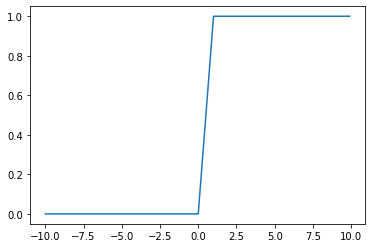

In [47]:
plt.plot(a, F.hardtanh(a, min_val=0, max_val=1))

In [ ]:
class L0Conv2d(Module):
    """Implementation of L0 regularization for the feature maps of a convolutional layer"""

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True,
                 droprate_init=0.5, temperature=2. / 3., weight_decay=1., lamba=1., local_rep=False, **kwargs):
        """
        :param in_channels: Number of input channels
        :param out_channels: Number of output channels
        :param kernel_size: Size of the kernel
        :param stride: Stride for the convolution
        :param padding: Padding for the convolution
        :param dilation: Dilation factor for the convolution
        :param groups: How many groups we will assume in the convolution
        :param bias: Whether we will use a bias
        :param droprate_init: Dropout rate that the L0 gates will be initialized to
        :param temperature: Temperature of the concrete distribution
        :param weight_decay: Strength of the L2 penalty
        :param lamba: Strength of the L0 penalty
        :param local_rep: Whether we will use a separate gate sample per element in the minibatch
        """
        super(L0Conv2d, self).__init__()
        assert in_channels % groups != 0, 'in_channels must be divisible by groups'
        assert out_channels % groups != 0, 'out_channels must be divisible by groups'
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = pair(kernel_size)
        self.stride = pair(stride)
        self.padding = pair(padding)
        self.dilation = pair(dilation)
        self.output_padding = pair(0)
        self.groups = groups
        self.prior_prec = weight_decay
        self.lamba = lamba
        self.droprate_init = droprate_init if droprate_init != 0. else 0.5
        self.temperature = temperature
        self.floatTensor = torch.FloatTensor if not torch.cuda.is_available() else torch.cuda.FloatTensor
        self.use_bias = False
        
        self.weights = Parameter(torch.Tensor(out_channels, in_channels // groups, *self.kernel_size))
        self.qz_loga = Parameter(torch.Tensor(out_channels))
        self.dim_z = out_channels
        
        self.input_shape = None
        self.local_rep = local_rep

        h_out = lambda h_in, padding, dilation, kernel_size, stride: np.floor(
            (h_in + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) - 1) / stride[0] + 1)
        w_out = lambda w_in, padding, dilation, kernel_size, stride: np.floor(
            (w_in + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1) / stride[1] + 1)

        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
            self.use_bias = True

        self.reset_parameters()
        print(self)
        
        
    def forward(self):
        

In [31]:
weights.shape

torch.Size([16, 1, 5, 5])

In [28]:
c = L0Conv2d(c_in, c_out, 5)

L0Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), droprate_init=0.5, temperature=0.6666666666666666, prior_prec=1.0, lamba=1.0, local_rep=False)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:173: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [30]:
c.__repr__()

'L0Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), droprate_init=0.5, temperature=0.6666666666666666, prior_prec=1.0, lamba=1.0, local_rep=False)'